In [1]:
import jax.numpy as jnp
import jax
import numpy as np
import matplotlib.pyplot as plt
from jax import grad, jit, vmap
import numpyro
from numpyro import distributions as dist
from numpyro import infer

from numpyro_ext import distributions as distx
from numpyro_ext import info, optim

jax.config.update("jax_enable_x64", True)
numpyro.set_host_device_count(2)

from jaxoplanet import light_curves, orbits
import arviz as az
import corner

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Transit fitting tutorial in jaxoplanet:

In this tutorial, I will attempt to reproduce the transit fitting example code in exoplanet (https://gallery.exoplanet.codes/tutorials/transit/) using the package jaxoplanet. Jaxoplanet is built on the Jax autodiff package, so it allows us to do gradient based inference. I will be using Numpyro for the sampling and also will demonstrate the ability to switch between Hamiltonian Monte Carlo and Nested Sampling with jaxns.

Warning, this code is meant to reproduce the exoplanet docs as exactly as possible! Plagiarism is the point (with [attribution](https://gallery.exoplanet.codes/tutorials/transit/) of course).

*jaxoplanet* includes methods for computing the light curves transiting planets. In its simplest form this can be used to evaluate a light curve like you would do with [batman](https://github.com/lkreidberg/batman), for example:

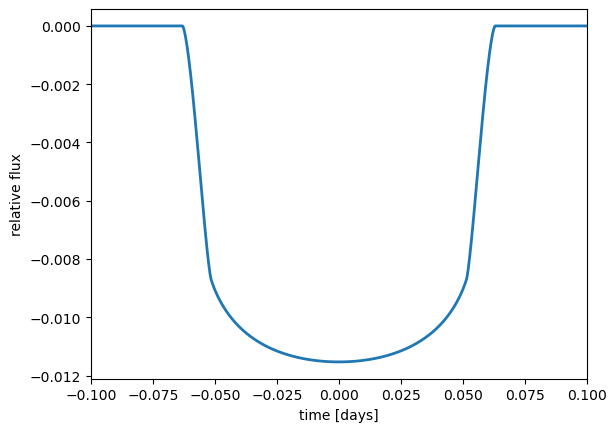

In [2]:
# The light curve calculation requires an orbit
orbit = orbits.KeplerianOrbit.init(period=3.456, radius=0.1)

# Compute a limb-darkened light curve using starry
t = jnp.linspace(-0.1, 0.1, 1000)
u = [0.3, 0.2]
lc = light_curves.QuadLightCurve(u[0], u[1]).light_curve(orbit, t=t)

plt.plot(t, lc[0], color="C0", lw=2)
plt.ylabel("relative flux")
plt.xlabel("time [days]")
_ = plt.xlim(t.min(), t.max())

But the real power comes from being able to do gradient based inference with jax

# The transit model in NumPyro:

In this section, we will construct a simple transit fit model using NumPyro and then we will fit a two planet model to simulated data. To start, let’s randomly sample some periods and phases and then create a test light curve:

In [3]:
import numpy as np

def fold(period, t0, time, flux):
    phase = ((time - (t0-0.5*period)) % period) / period - 0.5
    sorted_indices = np.argsort(phase)
    phase_sorted = phase[sorted_indices]
    flux_sorted = flux[sorted_indices]
    
    return phase_sorted, flux_sorted

def light_curve(params, t):
    # The light curve calculation requires an orbit
    orbit = orbits.KeplerianOrbit.init(period=params['period'], radius=params['radius'],time_transit=params['t0'])
    # Compute a limb-darkened light curve using starry
    lc = light_curves.QuadLightCurve(u1=params['u'][0], u2=params['u'][1]).light_curve(orbit, t=t)
    return lc[0]

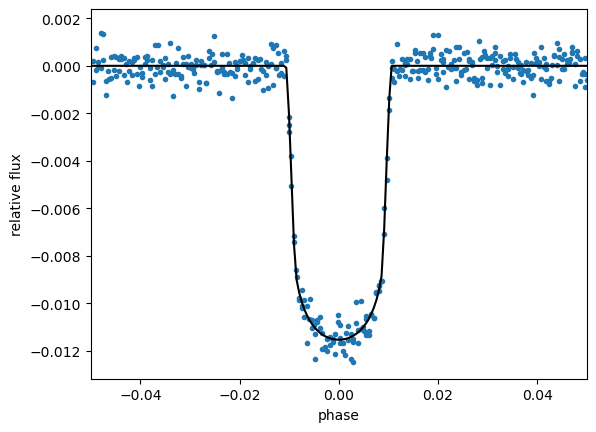

In [4]:
np.random.seed(11)
period_true = np.random.uniform(5, 20)
t0_true = np.random.uniform(low=0, high=5.0)
t = np.arange(0, 80, 0.02)
yerr = 5e-4

true_params = {'period':period_true,
               't0':t0_true,
               'radius':0.1,
               'u':jnp.array([0.3, 0.2])
} 


# Compute a limb-darkened light curve using starry
lc_true = light_curve(true_params, t)

lc = lc_true + yerr*np.random.normal(size=len(t))

phase, flux = fold(period_true, t0_true, t, lc)
_, flux_true = fold(period_true, t0_true, t, lc_true)

plt.plot(phase, flux, 'C0.')
plt.plot(phase,flux_true,color='k')
plt.ylabel("relative flux")
plt.xlabel("phase")
_ = plt.xlim(-0.05, 0.05)

In [5]:
def model(t, yerr, y=None):
    # If we wanted to fit for all the parameters, we could use the following,
    # but we'll keep these fixed for simplicity.
    # log_duration = numpyro.sample("log_duration", dist.Uniform(jnp.log(0.08), jnp.log(0.2)))
    # b = numpyro.sample("b", dist.Uniform(0.0, 1.0))

    log_jitter = numpyro.sample("log_jitter", dist.Normal(jnp.log(yerr), 1.0))
    u = numpyro.sample("u", distx.QuadLDParams())
    period = numpyro.sample("period", dist.Normal(period_true,0.01))
    t0 = numpyro.sample("t0", dist.Normal(t0_true+0.01, 0.1))
    numpyro.deterministic("t0_minutes", t0 * 24 * 60)
    log_r = numpyro.sample("log_r", dist.Normal(jnp.log(0.1), 2.0))
    r = numpyro.deterministic("r", jnp.exp(log_r))
    params = {
        "u": u,
        "t0": t0,
        "radius": r,
        "period": period,
    }

    numpyro.sample(
        "flux",
        dist.Normal(
            light_curve(params, t), jnp.sqrt(yerr**2 + jnp.exp(2 * log_jitter))
        ),
        obs=y,
    )

In [6]:
sampler_wn = infer.MCMC(
    infer.NUTS(
        model,
        dense_mass=True,
        target_accept_prob=0.9,
        init_strategy=infer.init_to_value(values=true_params),
    ),
    num_warmup=1000,
    num_samples=2000,
    num_chains=2,
    progress_bar=True,
)
%time sampler_wn.run(jax.random.PRNGKey(11), t, yerr, lc)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

CPU times: user 1h 37min 34s, sys: 2min 41s, total: 1h 40min 15s
Wall time: 47min 29s


In [8]:
inf_data_wn = az.from_numpyro(sampler_wn)
az.summary(inf_data_wn, var_names=["t0", "r",'period','u'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
t0,0.098,0.000,0.097,0.099,0.000,0.000,3920.0,2722.0,1.0
r,0.100,0.000,0.100,0.101,0.000,0.000,2472.0,2254.0,1.0
period,7.704,0.000,7.704,7.704,0.000,0.000,4113.0,2922.0,1.0
u[0],0.285,0.076,0.146,0.436,0.002,0.001,1380.0,1297.0,1.0
u[1],0.230,0.122,0.009,0.468,0.003,0.003,1322.0,1421.0,1.0


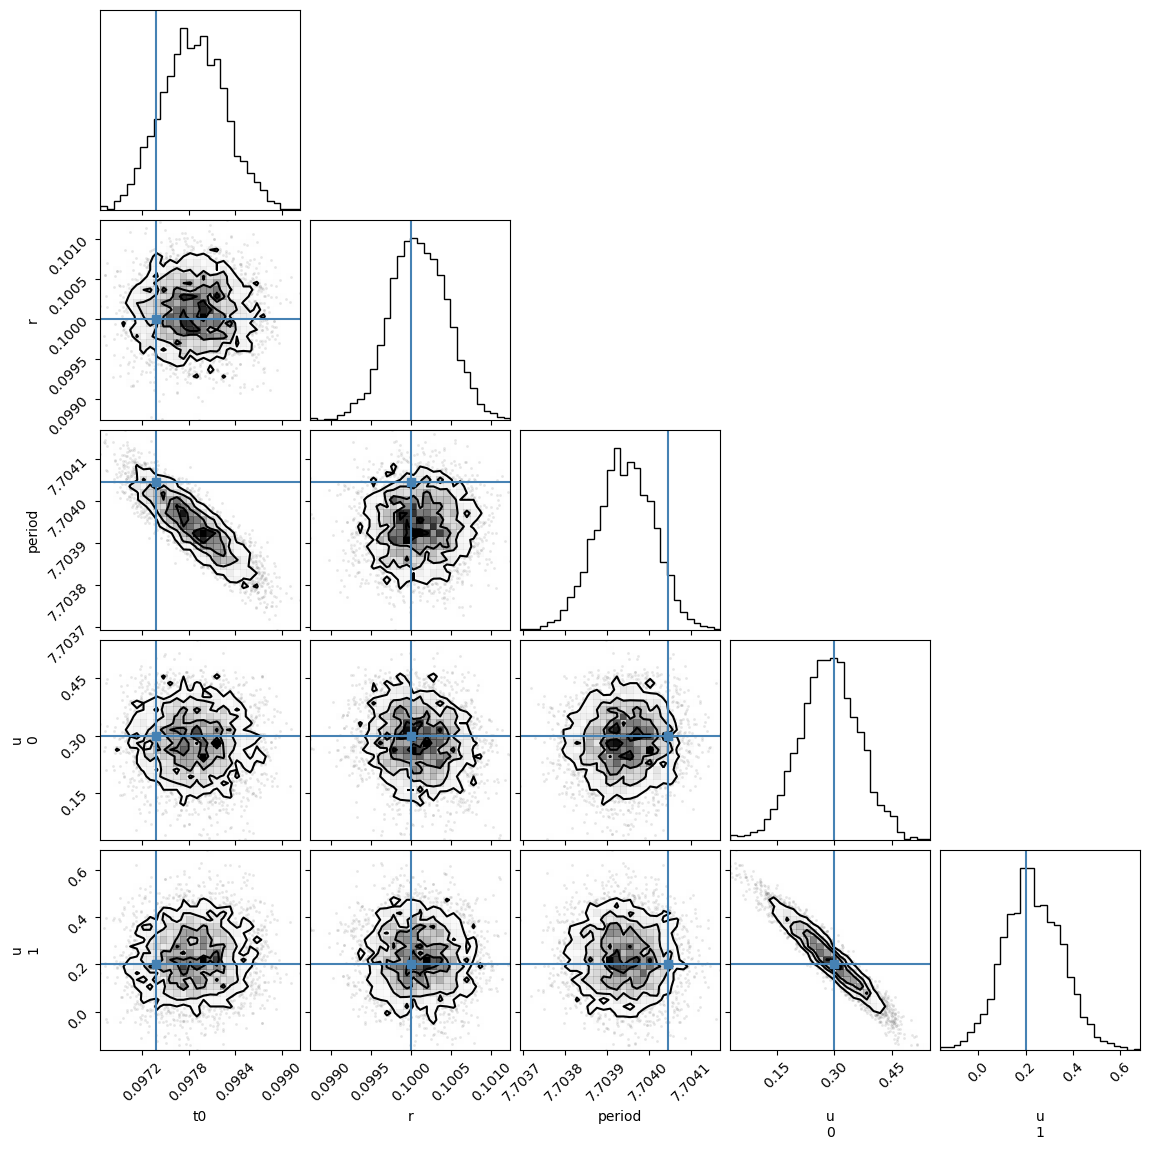

In [15]:
corner_params = true_params
corner_params['r'] = true_params['radius']
fig = corner.corner(
    inf_data_wn, bins=30, var_names=["t0", "r",'period','u'], color="k", truths=true_params
)